YOLOv3 | Keras implementation
-----

To retrieve yolov3 weights I used this [GitHub : qqweee, keras-yolov3](https://github.com/qqwweee/keras-yolo3).

## Load packages

In [1]:
from __future__ import print_function

from tensorflow import keras
import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras import Model

# from model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss

import numpy as np
import sys
import cv2

import os
import gc

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.__version__

'2.1.0'

In [3]:
def clean_session():
    K.clear_session()
    gc.collect()

In [4]:
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load model

In [5]:
model_path = '../keras-yolo3/model_data/yolo.h5'

In [6]:
model = tf.keras.models.load_model(model_path)

In [7]:
def find_layer(layers, name):
    """
    """
    for i, e in enumerate(layers):
        if 'name' not in e:
            continue
        if e['name'] == name:
            return i, e
    return None, None

def update_yolo_config(model, output_shape=45):
    """
    """
    config = model.get_config()
    output = config['output_layers']
    
    for layer in output:
        idx, layer = find_layer(config['layers'], name=layer[0])
        layer['config']['filters'] = output_shape
#         print(layer)
#         print()
        config['layers'][idx] = layer
    
    return config

def update_yolo_weight(model, output_shape=45):
    """
    """
    weights = model.get_weights()
    
    weights[-1] = weights[-1][..., :output_shape]
    weights[-2] = weights[-2][..., :output_shape]
    weights[-3] = weights[-3][..., :output_shape]
    weights[-4] = weights[-4][..., :output_shape]
    weights[-5] = weights[-5][..., :output_shape]
    weights[-6] = weights[-6][..., :output_shape]
    
    return weights

def new_yolo_model(model, output_shape):
    """
    """
    new_config = update_yolo_config(model, output_shape)
    new_weights = update_yolo_weight(model, output_shape)
    
    new_model = Model.from_config(new_config)
    new_model.set_weights(new_weights)

    return new_model

clean_session()
new_model = new_yolo_model(model, output_shape=45)

In [8]:
del model
gc.collect()

77914

In [28]:
exemple = np.array([[[1,2,3],[1,2,3],[1,2,3]],[[4,5,6],[4,5,6],[4,5,6]]])

print(exemple.shape)
print()
print(exemple)

exemple[..., 2].T

(2, 3, 3)

[[[1 2 3]
  [1 2 3]
  [1 2 3]]

 [[4 5 6]
  [4 5 6]
  [4 5 6]]]


array([[3, 6],
       [3, 6],
       [3, 6]])

In [9]:
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, None, None, 3 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [19]:
new_model.output

[<tf.Tensor 'conv2d_59/Identity:0' shape=(None, None, None, 45) dtype=float32>,
 <tf.Tensor 'conv2d_67/Identity:0' shape=(None, None, None, 45) dtype=float32>,
 <tf.Tensor 'conv2d_75/Identity:0' shape=(None, None, None, 45) dtype=float32>]

## Load data and plot it

In [10]:
def load_annotations(annot_path):
    with open(annot_path, 'r') as f:
        txt = f.readlines()
        annotations = [line.strip() for line in txt if len(line.strip().split()[1:]) != 0]
    np.random.shuffle(annotations)
    
    return annotations

In [11]:
train_path = "../YOLOV3/data/dataset/yymnist_train.txt"
test_path = "../YOLOV3/data/dataset/yymnist_train.txt"
train = load_annotations(train_path)
test = load_annotations(test_path)

In [12]:
def parse_annotation(annotation, resize_shape=(416,416)):
    """Format annotation from MNIST dataset
    
    Parameters
    ----------
    annotation: list
        list of string containing img_path and (bboxes, class) 
        separated by space
    resize_shape: tuple (default (416,416))
        Shape to resize 
        
    Returns
    -------
    np.array:
        image formated as array with value between 0 and 1 (scale to 1/255) 
        shaped (resize_shape[0], resize_shape[1], 3)
    list:
        List of bboxes containing bbox items : 
        [x_top_left, y_top_left, x_bot_right, y_bot_right, class]
    """
    line = annotation.split()
    image_path = line[0]
    
    # update path stored to correspond to the notebook path 
    image_path = '../YOLOV3' + image_path.split('YOLOV3/')[-1][1:]
    
    if not os.path.exists(image_path):
        raise KeyError("%s does not exist ... " %image_path)
        
    image = cv2.imread(image_path)
    image = cv2.resize(image, resize_shape)
    bboxes = np.array([list(map(int, box.split(','))) for box in line[1:]])
    
    image = img_to_array(image) / 255
    
    return image, bboxes

def box_in_cell(x, y, grid_box):
    """Returns whether a point (x, y) is in a box (x1,y1,x2,y2)
    
    Parameters
    ----------
    x: number
        X coordinate
    y: number
        Y coordinate
    grid_box: tuple
        x1,y1,x2,y2 for which x1,y1 is the top left corner
        and x2,y2 the bottom right corner
    
    Returns
    -------
    bool:
        whether the point is in the grid or not
    """
    x1_g, y1_g, x2_g, y2_g = grid_box
    return (x >= x1_g) & (x < x2_g) & (y >= y1_g) & (y < y2_g)

def get_w_h(image_shape, grid_shape):
    """Returns four attributes : cell width, height and grid width and height
    
    Parameters
    ----------
    image_shape: tuple
        image width, image height
    grid_shape: tuple
        grid width, grid height
        
    Returns
    -------
    float:
        cell width
    float:
        cell height
    float:
        grid width
    float:
        grid height
    """
    cell_w, cell_h = image_shape
    grid_w, grid_h = grid_shape
    cell_w, cell_h = cell_w / grid_w, cell_h / grid_h
    
    return cell_w, cell_h, grid_w, grid_h
    

def format_bbox_to_output_shape(bboxes, image_shape, grid_shape, nb_classes, anchors=None):
    """Format bboxes to be shaped for output layer in a neural network.
    
    Input shape for bboxes is (m, 5) with x1,y1,x2,y2,class as 2nd dim
    
    Output shape is (m, grid_w, grid_h, 5+nb_classes)
    
    Parameters
    ----------
    bboxes: list
        list of bbox shape with class
        shape (m, 5)
    image_shape: tuple
        image width, image height
    grid_shape: tuple
        grid width, grid height
    nb_classes: int
        Number of class
    anchors: list
        List of anchors (width, height)
        
    Returns
    -------
    np.array:
        true bboxes shape (m, grid_w, grid_h, 5+nb_classes)
    """
    m = len(bboxes)
    cell_w, cell_h, grid_w, grid_h = get_w_h(image_shape, grid_shape)
    
    bboxes_format = np.zeros(shape=(m, grid_w, grid_h, 5+nb_classes))
    
    for i in range(m):
        for row in range(grid_w):
            for col in range(grid_h):
                for b in bboxes[i]:
                    x1,y1,x2,y2,c = b
                    w, h = x2-x1, y2-y1
                    x, y = x1 + w/2, y1 + h/2
                    grid_box = (row*cell_w, col*cell_h, (row+1)*cell_w, (col+1)*cell_h)

                    if not box_in_cell(x, y, grid_box):
                        continue

                    w, h = w/cell_w, h/cell_h
                    x, y = (x-(row*cell_w))/cell_w, (y-(col*cell_h))/cell_h

                    class_score = [0 for i in range(nb_classes)]
                    class_score[c] = 1

                    bboxes_format[i, row, col] = np.array([1,x,y,w,h]+class_score)
                
    return bboxes_format
    

def plot_img(img, true_bboxes, image_shape, grid_shape):
    """Plot an images with it's bboxes detected on the image
    
    Parameters
    ----------
    img: np.array
        image formated as array
    true_bboxes: np.array
        true bboxes shape (m, grid_w, grid_h, 5+nb_classes)
    image_shape: tuple
        image width, image height
    grid_shape: tuple
        grid width, grid height
    """
    fig, ax = plt.subplots(figsize=(5,5))
    
    imgplot = plt.imshow(img)
    cell_w, cell_h, grid_w, grid_h = get_w_h(image_shape, grid_shape)    
    
    for row in range(grid_w):
        plt.axvline(x=row*cell_w)
        
        for col in range(grid_h):
            plt.axhline(y=col*cell_h)
            
            b = true_bboxes[row,col,:]
            
            p_obj, x, y, w, h, p_classes = b[0],b[1],b[2],b[3],b[4],b[5:]

            if p_obj < 0.5:
                continue
                
            w, h = w*cell_w, h*cell_h
            x1, y1 = row*cell_w + x - w/2, col*cell_h + y - h/2 
            x1, y1 = row*cell_w + x*cell_w - w/2, col*cell_h + y*cell_h - h/2
            rect = patches.Rectangle((x1, y1), w, h, linewidth=1, edgecolor='r',facecolor='none')
            
            pred = np.argmax(p_classes)            
            ax.text( x1-10, y1-10, "class = %s" % str(pred), color='r')
            
            ax.add_patch(rect)
    
    plt.show()


def format_data(annotations, resize_shape, grid_shape, nb_classes, anchors):
    """Format a dataset
    """
    images = list()
    bboxes = list()
    
    for annotation in annotations:
        image, img_bboxes = parse_annotation(annotation, resize_shape)
        images.append(image)
        bboxes.append(img_bboxes)
        gc.collect()
    
    images = np.array(images)
    bboxes = np.array(bboxes)
    gc.collect()
    
    true_bboxes = format_bbox_to_output_shape(bboxes, resize_shape, 
                                              grid_shape=grid_shape, nb_classes=nb_classes)
    
    return images, true_bboxes

In [13]:
%%time
resize_shape = (416,416)
grid_shape = (52,52)
anchors = [(100,50), (50,100), (75,25)]
nb_classes = 10

images, true_bboxes = format_data(train[:10], resize_shape, grid_shape, nb_classes, anchors)

print('X train shape:', images.shape)
print('Y train shape:', true_bboxes.shape)

X train shape: (10, 416, 416, 3)
Y train shape: (10, 52, 52, 15)
CPU times: user 3.17 s, sys: 3.43 ms, total: 3.17 s
Wall time: 3.3 s


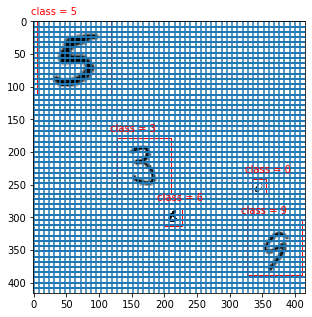

In [14]:
idx = 3
plot_img(images[idx], true_bboxes[idx], resize_shape, grid_shape)

In [15]:
gc.collect()

218267

## Create model

In [16]:
clean_session()
preds = new_model.predict(images[0:3])

In [17]:
len(preds) #.shape

3

In [20]:
preds[0].shape, preds[1].shape, preds[2].shape

((3, 13, 13, 45), (3, 26, 26, 45), (3, 52, 52, 45))

In [52]:
images.shape

(10, 416, 416, 3)

In [18]:
from tensorflow.keras.utils import plot_model
plot_model(new_model, to_file='model.png')

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [64]:
from IPython.display import SVG
from tensorflow.keras.

SVG(model_to_dot(new_model).create(prog='dot', format='svg'))

ImportError: cannot import name 'model_to_dot'